 #Inference :

##This notebook is used for testing the inference before production 

In [1]:
#load the libraries
import tensorflow as tf
import time
import numpy as np
from PIL import Image
import cv2
from object_detection.protos import string_int_label_map_pb2
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
import matplotlib.pyplot as plt
import glob
import warnings
warnings.filterwarnings('ignore')

2025-04-07 07:45:35.446833: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-07 07:45:36.370890: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-04-07 07:45:36.371005: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-04-07 07:45:36.371017: W tensorfl

In [ ]:
# Set the desired output image size
IMAGE_SIZE = (6, 6)

# Load the saved model , change the path to your respective exported model dir
PATH_TO_SAVED_MODEL = "/home/poornimadevikr/git/mymodels/models/inference_graph"
# Update with your saved model path
print('Loading model...', end='')



Loading model...

In [3]:
# Load the saved model and build the detection function
detect_fn = tf.saved_model.load("/home/poornimadevikr/git/mymodels/models/inference_graph/saved_model")
print('Done!')



2025-04-07 07:45:39.099769: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/poornimadevikr/git/mymodels/models/.venv_ssd_3.7/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-04-07 07:45:39.099822: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-04-07 07:45:39.099888: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2025-04-07 07:45:39.100106: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow 

Done!


#Testing inference with image resize 

In [ ]:
# Load the label map, give the path to the label_map.pbtxt of your dataset
category_index1= label_map_util.create_category_index_from_labelmap("/home/poornimadevikr/git/mymodels/models/Mydata/coverttfrecord.v1i.tfrecord/valid/validlabel_map.pbtxt", use_display_name=True)


In [6]:
# function to resize while maintaining aspect ratio
def load_image_into_numpy_array_new(path, target_size=(320, 320)):
    """Load an image from file into a numpy array (removes alpha channel if present) 
       and resizes it to a target size while maintaining aspect ratio (no padding), keeping RGB format.
    """
    try:
        img = Image.open(path)
        img = np.array(img)

        # Debugging: check image shape and type
        print(f"Original Image shape: {img.shape}")
        print(f"Image dtype: {img.dtype}")

        # Check if the image has 4 channels (RGBA), and slice it to RGB
        if img.shape[-1] == 4:
            img = img[:, :, 0:3]  # Remove the alpha channel
        
        # Check new shape after removing alpha channel
        print(f"Image shape after removing alpha channel (if present): {img.shape}")

        # Get original image size
        original_width, original_height = img.shape[1], img.shape[0]
        print(f"Original Width: {original_width}, Original Height: {original_height}")
        
        # Calculate the aspect ratio
        aspect_ratio = original_width / original_height
        print(f"Aspect Ratio: {aspect_ratio}")

        # Resize while maintaining the aspect ratio
        if aspect_ratio > 1:  # Width > Height
            new_width = target_size[1]
            new_height = int(target_size[1] / aspect_ratio)
        else:  # Height >= Width
            new_height = target_size[0]
            new_width = int(target_size[0] * aspect_ratio)

        print(f"Resizing to: New Width: {new_width}, New Height: {new_height}")

        # Resize the image to the new dimensions
        img_resized = Image.fromarray(img)
        img_resized = img_resized.resize((new_width, new_height), Image.ANTIALIAS)

        # Convert resized image back to numpy array (still in RGB format)
        img_resized = np.array(img_resized)

        return img_resized

    except Exception as e:
        print(f"Error: {e}")
        return None

In [ ]:
# Path to the image
resize_imagepath = "//home/poornimadevikr/git/mymodels/models/research/my_test_images/traintest1.jpg"
# use this for padding 
# padding_imagepath = "//home/poornimadevikr/git/mymodels/models/research/my_test_images/traintest1.jpg"

In [8]:
# Load and preprocess the image
image_np = load_image_into_numpy_array_new(resize_imagepath)

# Prepare the input tensor for inference
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.uint8)

# Run inference (assuming you have the 'detect_fn' ready)
detections = detect_fn(input_tensor)

# Extract the detection results
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
detections['num_detections'] = num_detections

# Convert detection classes to integers
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)


Original Image shape: (640, 640, 3)
Image dtype: uint8
Image shape after removing alpha channel (if present): (640, 640, 3)
Original Width: 640, Original Height: 640
Aspect Ratio: 1.0
Resizing to: New Width: 320, New Height: 320


In [ ]:
path = "//home/poornimadevikr/git/mymodels/models/research/my_test_images/traintest1.jpg"

def load_image_into_numpy_array(path, target_size=(320, 320)):
# use this function for padding the image, run the load_image_into_numpy_array_new2 
# def load_image_into_numpy_array_new2(path, target_size=(320, 320)):
    """Load an image from file into a numpy array (removes alpha channel if present) 
       and resizes it to a target size while maintaining aspect ratio (no padding), keeping RGB format.
    
    Args:
      path: the file path to the image.
      target_size: tuple of (height, width) for the resized image.
    
    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    img = Image.open(path)
    img = np.array(img)

    # Check if the image has 4 channels (RGBA), and slice it to RGB
    if img.shape[-1] == 4:
        img = img[:, :, 0:3]  # Remove the alpha channel
    
    # Get original image size
    original_width, original_height = img.shape[1], img.shape[0]
    
    # Calculate the aspect ratio
    aspect_ratio = original_width / original_height

    # Resize while maintaining the aspect ratio
    if aspect_ratio > 1:  # Width > Height
        new_width = target_size[1]
        new_height = int(target_size[1] / aspect_ratio)
    else:  # Height >= Width
        new_height = target_size[0]
        new_width = int(target_size[0] * aspect_ratio)

    # Resize the image to the new dimensions
    img_resized = Image.fromarray(img)
    img_resized = img_resized.resize((new_width, new_height), Image.ANTIALIAS)

    # Convert resized image back to numpy array (still in RGB format)
    img_resized = np.array(img_resized)

    return img_resized


# Load the image
image_np = load_image_into_numpy_array(path)


# Prepare the input tensor for inference
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.uint8)

# Run inference (assuming you have the detection function ready)
detections = detect_fn(input_tensor)

# Extract the detection results
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
detections['num_detections'] = num_detections

# Convert detection classes to integers
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

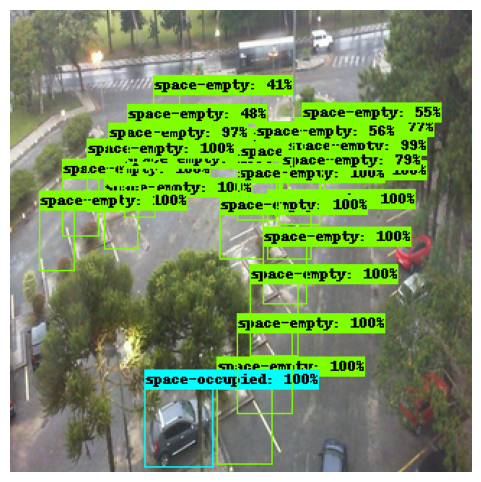

In [10]:

# Visualize the detection results on the image
def show_inference(image_np, boxes, classes, scores, category_index1, threshold=0.5):
    image_with_boxes = image_np.copy()

    # Iterate through the detections and draw the boxes
    for i in range(boxes.shape[0]):
        if scores[i] > threshold:
            box = boxes[i]
            class_id = int(classes[i])
            label = category_index1[class_id]['name']
            score = scores[i]

            # Convert the box coordinates to pixel values (e.g., x_min, y_min, x_max, y_max)
            y_min, x_min, y_max, x_max = box
            x_min, x_max = int(x_min * image_np.shape[1]), int(x_max * image_np.shape[1])
            y_min, y_max = int(y_min * image_np.shape[0]), int(y_max * image_np.shape[0])

            # Draw the bounding box and label
            image_with_boxes = cv2.rectangle(image_with_boxes, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            label_text = f'{label}: {score:.2f}'
            image_with_boxes = cv2.putText(image_with_boxes, label_text, (x_min, y_min - 10),
                                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Call the visualization function
show_inference(image_np, detections['detection_boxes'], detections['detection_classes'],
                detections['detection_scores'], category_index1)
# Create a copy of the image with bounding boxes and labels
image_np_with_detections = image_np.copy()
# Visualize the detections on the image
viz_utils.visualize_boxes_and_labels_on_image_array(
 image_np_with_detections,
 detections['detection_boxes'],
 detections['detection_classes'],
 detections['detection_scores'],
 category_index1,
 use_normalized_coordinates=True,
 max_boxes_to_draw=100,
 min_score_thresh=0.4, # Adjust this value to set the minimum probability for boxes to be classified as True
 agnostic_mode=False,
 line_thickness=1
)
# Display the image with detections
%matplotlib inline
plt.figure(figsize=IMAGE_SIZE, dpi=100)
plt.axis("off")
plt.imshow(image_np_with_detections)
plt.show()

Image with padding

In [11]:
def load_image_into_numpy_array_new2(path, target_size=(320, 320)):
    img = Image.open(path)
    img = np.array(img)

    # Check if the image has 4 channels (RGBA), and slice it to RGB
    if img.shape[-1] == 4:
        img = img[:, :, 0:3]  # Remove the alpha channel
    
    original_width, original_height = img.shape[1], img.shape[0]
    aspect_ratio = original_width / original_height

    if aspect_ratio > 1:
        new_width = target_size[1]
        new_height = int(target_size[1] / aspect_ratio)
    else:
        new_height = target_size[0]
        new_width = int(target_size[0] * aspect_ratio)

    img_resized = Image.fromarray(img)
    img_resized = img_resized.resize((new_width, new_height), Image.LANCZOS)

    padded_image = Image.new('RGB', target_size, (0, 0, 0))
    left = (target_size[1] - new_width) // 2
    upper = (target_size[0] - new_height) // 2
    right = left + new_width
    lower = upper + new_height
    padded_image.paste(img_resized, (left, upper, right, lower))

    img_padded = np.array(padded_image)

    return img_padded